<a href="https://colab.research.google.com/github/prasama/ear/blob/main/ProbSevere_v3_predictor_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Predictor Importance in ProbSevere for Different Environments

Creator(s):
-  John Cintineo, NOAA National Severe Storms Laboratory (NOAA/NSSL)
-  Scott Lindstrom, Cooperative Institute for Meteorological Satellite Studies (CIMSS), University of Wisconsin -- Madison (UW-Madison)

History: Created: May 2024




## Overview
In this notebook, we explore how NOAA's ProbSevere version 3 (v3) severe-weather nowcasting models make predictions, and how predictor importance changes for different storms in different environments.


## Prerequisites
To successfully navigate and use this notebook, you should be accustomed with:

-  The basics of Python programming (e.g., loading modules, variable assignment, plotting, familiarity with scientific Python packages)
-  Basic understanding of navigating in a Linux environment
-  A basic familiarity with atmospheric convection (not required)

## Learning Outcomes
By working through this notebook, you should have:
-  Increased understanding of important predictors in severe-weather nowcasting
-  A basic understanding or now to tina predictor Importances in a tree-based machine learning model using Python and associated llbrarles
-  Familiarity with some differences in predictor importances among different meteorological environments

## Expected Completion time
-  Active use: 60 minutes

<hr>

# Tutorial

## Severe convective weather background

Severe thunderstorms arise from a potent mix of ingredients ("SLIM"):

1.   Shear
2.   Lift
3.   Instability
4.   Moisture

Warm, moist air near the surface and cooler air aloft in the atmosphere creates instability. As warm air rises, it cools and condenses, releasing energy that fuels the storm's development.

The air near the surface rises either due warming and reaching the "[convective temperature](https://en.wikipedia.org/wiki/Convective_temperature)," or the air is mechanically forced upward by a lifting mechanism (e.g., cold front, dryline, low-pressure system, upslope flow, etc.).

This rising stream of air, known as a convective updraft, will create a thunderstorm if strong enough---that is, when the separation of ice, liquid, and supercooled water particles create a charge difference, resulting in [lightning](http://www.atmo.arizona.edu/students/courselinks/fall15/atmo336/lectures/sec2/lightning.html).

What separates benign thunderstorms from severe thunderstorms most often is wind shear, the change in wind speed or direction with height. Strong wind shear can tilt the updraft, displacing it from the storm's downdraft, allowing the updraft to sustain itself for a longer period of time. This enables the development of a mesocyclone, and allows rotating air to be ingested into the updraft.

There are several "modes" of severe convective storms, each with its own characteristic threats.
- Squall lines, or long bands of thunderstorms, can produce damaging wind gusts and heavy rain leading to flash floods. These are often characterized by moderate wind shear.
- Supercell thunderstorms, with their rotating updrafts, are particularly dangerous as they can spawn large hail, tornadoes, and very strong straight-line winds. Supercells often have very high wind shear (> 40 kt).
- Derechos, widespread and long-lived wind events caused by severe thunderstorms moving in the same direction over a long period, can cause significant damage across a large area.
- Wet microbursts, often associated with only modest wind shear, have warm and very moist low levels and dry mid-levels. Evaporative cooling in the mid-levels creates downard buoyancy, or sinking air. If the rush of sinking air is strong enough, this can be very damaging.
- Dry microbursts have very dry low-levels as well as often dry mid-levels, with further sub-cloud evaporation of precipitation increasing the negative buoyancy. The evaporation of precipitation can be total, resulting in no precipitation reaching the ground.
- Other severe storm modes exist as well.

## ProbSevere v3 background

ProbSevere is a system to predict severe weather using satellite, radar, lightning, and storm environment attributes, and has evolved since its inception in 2008. One of the earlier attempts at monitoring convection from satellite included cloud-top cooling (that is, viewing the change in the longwave infrared brightness temperature); the very quick cooling of a cloud-top can be interpreted as explosive growth in the vertical, which is behavior that is well correlated with later severe weather. Cloud glaciation trends were also considered.

Later, ProbSevere (v1) was developed using machine learning to include different radar fields and numerical model output and ground-based lightning observations. ProbSevere versions 2 and 3 were further refinements in the input fields (GLM has been added, for example, as well as the IntenseStormNet parameter fields).With each refinement, the machine-learning tool has become more reliable, that is, it has better statistical performance at making predictions.

## Shapely and SHAP

### Shapley Values

Shapley values are a game theory concept used to explain the contribution of individual features to a prediction made by a machine learning model. Imagine each feature value in a data instance as a player in a collaborative game, and the model's prediction is the payout they all contribute to. Shapley values quantify how much each feature value adds (or subtracts) to the prediction compared to a baseline prediction where none of the features contribute.

This approach helps us understand which features are most influential in a model's decision-making process, making complex models more interpretable.

### SHAP Python Library

The SHAP (SHapley Additive exPlanations) library is a Python package that allows you to calculate Shapley values for various machine learning models. In our case, for the ProbSevere gradient-boosted decision tree models.

Benefits of using SHAP:

- Provides a principled approach to explain model predictions.
- Works with various model types, including complex ones.
- Offers different visualizations to understand feature contributions globally (across all predictions) or locally (for a specific prediction). We'll be looking at "local" predictions.

Please read [SHAP's documentation](https://shap.readthedocs.io/en/latest/) if you'd like to learn more.

## Building the Python environment

This notebooks uses a Python environment with libraries such as `lightgbm`, `shap`, `numpy`, `pandas`, and `matplotlib`.

First, we need to install some packages into our Python environment.

In [ ]:
%%capture
# Python packages that we will use in this notebook
%matplotlib inline

!pip install lightgbm
!pip install shap
!pip install pandas

## Download data

First, we need to download the probability of any severe hazards model, and the probability of tornado model. These are pickled `scikit-learn` classifiers, but were trained using the `lightgbm` package.

We will also download time series data for certain storms that we want to investigate.

In [ ]:
# Download PSv3 (any-severe critera) and PTv3 (tornado) model files
!wget -q "https://bin.ssec.wisc.edu/pub/probsevere/satmoc_2024/psv3_lgb_classifier.pkl"  # PSv3 model
!wget -q "https://bin.ssec.wisc.edu/pub/probsevere/satmoc_2024/ptv3_lgb_classifier.pkl"  # PTv3 model

# Download time series for individual storms
!wget -R "index.html*" -nH --cut-dirs=3 -np -r -q "https://bin.ssec.wisc.edu/pub/probsevere/satmoc_2024/examples"


pathconf: Not a directory


Verify the downloaded files and `examples` directory.

In [ ]:
!ls
!ls examples/*

examples		 psv3_shap_vals.pkl	  ptv3_shap_vals.pkl
psv3_lgb_classifier.pkl  ptv3_lgb_classifier.pkl  sample_data
examples/dry_microburst.pickle	   examples/nontor_supercell.pickle  examples/wet_microburst.pickle
examples/Nebraska_20240426.pickle  examples/salado_tornado.pickle


## Feature importance function

Here we import some libraries and establish our feature importance function, `storm_shap`. We will run this on data from several storms in a few different ways.

It requires the `model_file` string, the `rad_obj_file` string, and a `timestamp` string (in the format of "%Y%m%d-%H%M", e.g., "20240426-1916"). The `force` and `decision` boolean arguments set which types of figures you want to produce (we will be using decision plots).

The `link` argument determins which type of "space" you want to operate in. "logit" means probability-space, so it shows you how much "probability percentage" each predictor affected the final prediction. This method is more intuitive, but less exact as the log-odds-space of "identity." We'll compare and contrast both methods.

In [ ]:
import lightgbm
import shap
import pickle
from datetime import datetime
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)

def storm_shap(model_file,
               rad_obj_file,
               timestamp,
               force=False,
               decision=False,
               link='logit'):
  """
  Calculate storm feature (i.e, predictor) importances for one storm, at a given time, for a given ProbSevere model.

  Args:
    model_file:   <string> Full path to the model file (usually a pickle)
    rad_obj_file: <string> Full path to a pickle file containing time series for probsevere storm attributes for one storm
    timestamp:    <string> Timestamp of pattern "%Y%m%d-%H%M"
    force:        <bool> Create a "force plot." Default is False.
    decision:     <bool> Create a "decision plot." Default is False.
    link:         <string> "logit" means probability-space; "identity" means log-odds-space, which is more exact. Default="logit".
  """


  model = pickle.load(open(model_file,'rb'))
  predictor_names = model.feature_name_

  model.params = {'objective':'binary'}

  explainer = shap.TreeExplainer(model)

  rf = pickle.load(open(rad_obj_file,'rb'))
  ts_dt = datetime.strptime(timestamp,'%Y%m%d-%H%M')
  date = int(timestamp[0:8]); hhmm = int(timestamp[9:13])
  ind = np.where((rf['valid_rad_dates'] == date) & (rf['valid_rad_times'] == hhmm))[0][0]

  # Make 1-row pickle from predictor_names and rf
  df_list = []
  for pn in predictor_names:
    try:
      if(pn == 'flash_rate'):
        try:
          df_list.append(np.max(rf[pn][np.max([0,ind-3]):ind+1]))
        except IndexError:
          df_list.append(np.round(rf[pn][ind]))
      elif(pn in ['max_compref','max_mesh','max_vil_density']):
        try:
          df_list.append(np.round(np.max(rf[pn][np.max([0,ind-2]):ind+1]),2))
        except IndexError:
          df_list.append(np.round(rf[pn][ind],2))
      elif(pn in ['max_llazshear','max_mlazshear','p98_mlazshear','p98_llazshear']):
        try:
          max_az = np.max(rf[pn][np.max([0,ind-2]):ind+1])
          max_az = np.round(max_az * 2.)/2. #round to nearest 0.5
          df_list.append(max_az)
        except IndexError:
          df_list.append(np.round(rf[pn][ind]))
      elif(pn == 'max_tltg_density'):
        try:
          df_list.append(np.max(rf[pn][np.max([0,ind-5]):ind+1]))
        except IndexError:
          df_list.append(rf[pn][ind])
      elif(pn == 'maxrc_emiss'):
        if(np.max(rf[pn][0:np.max([ind-1,1])]) > 0):
          df_list.append(np.max(rf[pn][0:np.max([ind-1,1])]))
        else:
          df_list.append(0)
      else:
          df_list.append(rf[pn][ind])
    except KeyError:
      df_list.append(rf['glm'][pn][ind])

  X_test = pd.DataFrame([df_list],columns=predictor_names)
  shap_values = explainer.shap_values(X_test)

  probval = np.round(model.predict_proba(np.array(df_list).reshape(1,len(df_list)),num_iteration=model.best_iteration_)[0][1],3)
  print("This model probability: ",probval)

  # Make cleaner feature names for the DataFrame
  new_DF_feature_names = []
  for pn in np.array(predictor_names):
    new_DF_feature_names.append(fnames([pn])[0])

  shap_df = pd.DataFrame(
      np.stack((np.array(new_DF_feature_names).T,
                np.round(np.array(df_list).T,2),
                np.round(shap_values[0],3).T),axis=1),
      columns=['PREDICTOR','VALUE','SHAP'])

  print(shap_df.sort_values('SHAP',ascending=False,ignore_index=True))

  if(decision):
    shap.decision_plot(explainer.expected_value, shap_values, features=X_test, link=link, show=False)

    # Make cleaner feature names for the decision plot
    ax = plt.gca()
    y_tick_labels = ax.get_yticklabels()
    plotted_names = [label.get_text() for label in y_tick_labels]
    better_fnames = fnames(plotted_names)
    ax.set_yticklabels(better_fnames)

    plt.show()

  if(force):
    shap.force_plot(explainer.expected_value, shap_values, X_test, matplotlib=True, link=link)




Here is a helper function to make cleaner predictor names in the print out and in our images.

In [ ]:
import sys

def fnames(feature_names):

    rad_vars = ['max_mesh','max_vil','max_compref','p98_mlazshear',
                'max_mlazshear','p98_llazshear','max_llazshear',
                'max_etop50','max_h50a0c','max_ref10','max_ref20']

    fnames = []

    for fn in feature_names:
        if fn == 'icp':
            fnames.append('Intense convection prob.')
        elif fn == 'maxrc_emiss':
            fnames.append('Norm. sat. growth rate')
        elif fn == 'max_mesh':
            fnames.append('MESH$_{max}$')
        elif fn == 'max_vil':
            fnames.append('VIL$_{max}$')
        elif fn == 'max_mlazshear':
            fnames.append('AzShear 3-6 km$_{max}$')
        elif fn == 'p98_mlazshear':
            fnames.append('AzShear 3-6 km$_{98th}$')
        elif fn == 'max_llazshear':
            fnames.append('AzShear 0-2 km$_{max}$')
        elif fn == 'p98_llazshear':
            fnames.append('AzShear 0-2 km$_{98th}$')
        elif fn == 'max_compref':
            fnames.append('MergedReflectivity$_{max}$')
        elif fn == 'max_etop50':
            fnames.append('EchoTop 50-dBZ$_{max}$')
        elif fn == 'max_h50a0c':
            fnames.append('Hgt 50-dBZ above 0$^{o}$C$_{max}$')
        elif fn == 'max_ref10':
            fnames.append('Reflectivity -10$^{o}$C$_{max}$')
        elif fn == 'max_ref20':
            fnames.append('Reflectivity -20$^{o}$C$_{max}$')
        elif fn == 'max_fed':
            fnames.append('Flash-extent density$_{max}$')
        elif fn == 'avg_group_area':
            fnames.append('Avg. group area$_{max}$')
        elif fn == 'flash_rate':
            fnames.append('Flash rate')
        elif fn == 'max_tltg_density':
            fnames.append('Total lightning density$_{max}$')
        elif fn == 'EBS_merged_smoothed':
            fnames.append('Eff. bulk shear')
        elif fn == 'MEANWIND_1-3kmAGL_merged_smoothed':
            fnames.append('Meanwind 1-3 km AGL')
        elif fn == 'SRW02KM_merged_smoothed':
            fnames.append('SR wind 0-2 km AGL')
        elif fn == 'SRW46KM_merged_smoothed':
            fnames.append('SR wind 4-6 km AGL')
        elif fn == 'SRH_01KM_merged_smoothed':
            fnames.append('SR helicity 0-1 km AGL')
        elif fn == 'MAX_LAPSERATE_26KM_merged_smoothed':
            fnames.append('Mid-level lapse rate')
        elif fn == 'LAPSERATE_03KM_merged_smoothed':
            fnames.append('Lapse rate 0-3 km AGL')
        elif fn == 'PWAT_merged_smoothed':
            fnames.append('Precipitable water')
        elif fn == 'WETBULB_0C_HGT_merged_smoothed':
            fnames.append('Wet-bulb 0$^o$C hgt')
        elif fn == 'SFC_LCL_merged_smoothed':
            fnames.append('Surface LCL hgt')
        elif fn == 'MLCAPE_merged_smoothed':
            fnames.append('MLCAPE')
        elif fn == 'MUCAPE_merged_smoothed':
            fnames.append('MUCAPE')
        elif fn == 'CAPE_M10M30_merged_smoothed':
            fnames.append('CAPE$_{-10C - -30C}$')
        elif fn == 'DCAPE_merged_smoothed':
            fnames.append('DCAPE')
        else:
            print(f"Can't find fname for {fn}."); sys.exit(1)

    return fnames

## Example storms

We will be demonstrating feature importances with SHAP for several storms:
- Strong tornadic storm
- A non-tornadic supercell
- Wet microburst
- Dry microburst
- High-shear / low-CAPE storm

### Non-tornadic supercell

Let's test this out on a non-tornadic supercell. This central Oklahoma storm split into two cells. We will compare predictor importances in the early stages and latter stages of its development. Read this [blog post](https://goesrhwt.blogspot.com/2023/09/probsevere-v3-for-couple-of-early.html) for more detail and context. The right split eventually produced hail up to 3" in diameter.

In the animation below:
- The green-to-red background is MRMS composite reflectivity in units of dBZ (red-pink-white signifies the presence of heavy rain or hail).
- The storm contours are from ProbSevere v3, colored by the probability of any-severe (purple --> blue --> pink).
  - The outer contour on the right splitting storm at the end of the animation is colored by the probability of tornado, the same colorbar in the top left.
- The yellow polygon boxes are official NWS severe thunderstorm warnings.

<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhyY5roLffZ6bXeksGQFSFwfsxJXFA4tHzNnKQ2wXh8pmuosUERYiknOAKm5w-IXCzufpV9Ne9xkJct7i3LR8fub8D2tIMq7bnaqjWGZti8_Cf-pHSCZM9mbMSaS3sgCxSIkfjP_BgFm996RKAahZ517KZ1k8dNe1lB5P8_I4Yaa8p-CDBFc6vDxuHE1PI/s1419/OK_20230923.gif" width=70%>

The two animations below show the evolution of the storm from GOES-16. The top is the 0.64 µm reflectance ("red" visible, channel 02). The bottom is the 10.3 µm brightness temperature (longwave-infrared window, channel 13). See if you can identify overshooting tops and above-anvil cirrus plumes.

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C02_20230923_2001_to_0924_0101_SEMINOLEanim.gif">

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C13_20230923_2001_to_0924_0101_SEMINOLEanim.gif">

Now let's look into predictor importance. The code cell below defines the `model`, the `rad_obj_file` (contains time series data for the given storm), and the `timestamp`. Then we execute `storm_shap` with `decision=True` and `link='logit'`.

In [ ]:
model = "psv3_lgb_classifier.pkl"
rad_obj_file = "examples/nontor_supercell.pickle"
timestamp = "20230923-2256"

storm_shap(model, rad_obj_file, timestamp, waterfall=True, link="logit")

[LightGBM] [Warning] min_data_in_leaf is set=32400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32400
[LightGBM] [Warning] feature_fraction is set=0.5333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333333333333333
[LightGBM] [Warning] lambda_l2 is set=0.16326530612244897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16326530612244897
[LightGBM] [Warning] lambda_l1 is set=0.7142857142857142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7142857142857142
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.375
                          PREDICTOR    VALUE    SHAP
0             Lapse rate 0-3 km AGL     8.42   0.677
1                            MLCAPE  3685.81   0.508
2                   Eff. bulk shear    46.39   0.446
3            Norm. sat. growth rate     2.74   0.416
4     

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In the output above, the printed-out table shows the predictor name, the value of that predictor, and the SHAP value. The order of predictors are ranked highest to lowest, except that predictors with negative SHAP are at the bottom, ranked by highest absolute value.

In the figure, the rankings are by absolute SHAP value (postive and negative values are mixed in). The colobar in the figure is for the final probability of severe. On this "decision plot," you begin from the bottom of the plot, following the line up until it reaches a value on the colobar; i.e., a probability. The greater deflections to the right show greater contributions of the predictor (on the same line) to the final probability. The values in parentheses on each line show the value of that predictor (units no provided).

In this case, the lapse rate 0-3 km, the MLCAPE, the effective bulk shear, and the satellite growth rate (Norm. sat. growth rate) were the top four highest-contributing predictors to a final probability of severe of 37.5%. The next highest predictors are MESH (maximum expected size of hail), with only 0.33", and the total lightning flash rate of only 5 flashes/min.

Let's take a look at the top predictors when the storm is more mature. Below, we are simply changing the timestamp to the time shortly after the storm split.



[LightGBM] [Warning] min_data_in_leaf is set=32400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32400
[LightGBM] [Warning] feature_fraction is set=0.5333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333333333333333
[LightGBM] [Warning] lambda_l2 is set=0.16326530612244897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16326530612244897
[LightGBM] [Warning] lambda_l1 is set=0.7142857142857142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7142857142857142
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.758
                          PREDICTOR    VALUE   SHAP
0                      MESH$_{max}$     1.25  1.015
1            AzShear 3-6 km$_{max}$     21.0  0.529
2             Lapse rate 0-3 km AGL     8.43  0.504
3                       VIL$_{max}$     37.4  0.486
4          

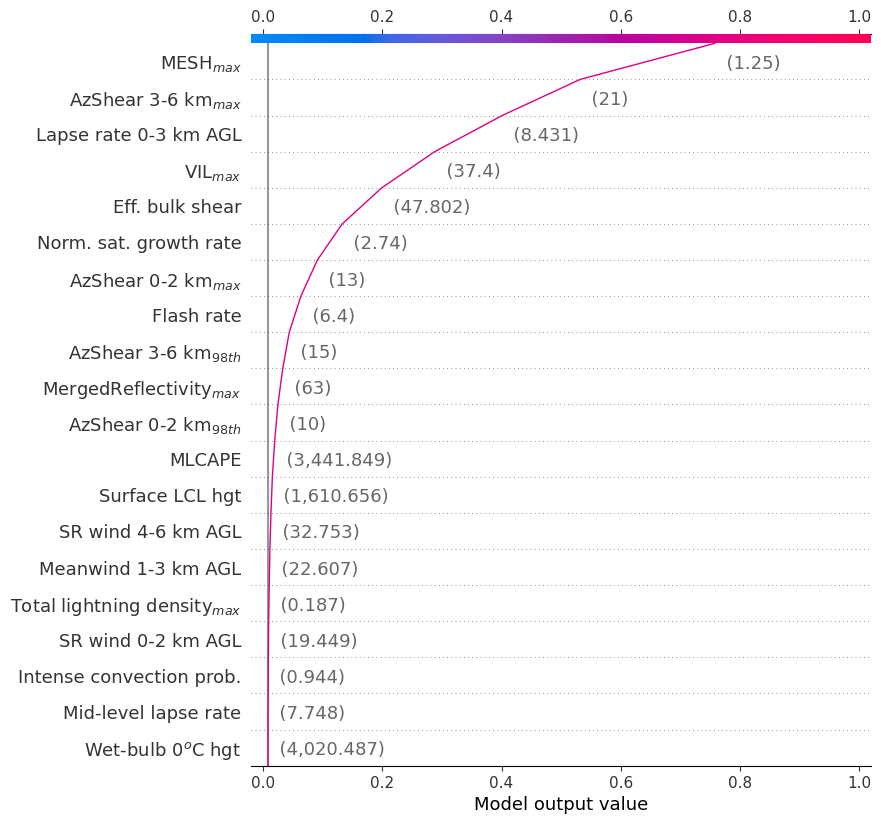

In [ ]:
model = "psv3_lgb_classifier.pkl"
rad_obj_file = "examples/nontor_supercell.pickle"
timestamp = "20230923-2344"

storm_shap(model, rad_obj_file, timestamp, decision=True, link="logit")

We now see the final probability is about 76%. The max MESH (1.25") and the strong mid-level storm rotation (21 x 10^3 / sec) are the top two contributing predictors, with the MESH alone contributing to about a 20% increase in the final probability! A strong VIL (vertically integrated liquid), another radar parameter, is also now a strong contriubing predictor.

In this case, we see how that **in the developing stage of this storm, the environment and the satellite predictors were more important than the radar predictors**. However, once the storm is mature, several of the **radar predictors are the top contributors**. This shows how using data fusion from numerous atmospheric observation sources really helps ProbSevere provide good probabilistic guidance throughout storm evolution.

Often, the satellite signal, in tandem with the environment and weak radar signatures, helps boost probabilities in the developing phase, providing forecasters with a "nudge" to further interrogate a storm.

### Wet microburst

Now let's repeat this process with a wet microburst, which can be  difficult to predict, because of how quickly they can produce severe wind gusts with little notice from radar signatures. This storm was crossing the Mississippi River from Arkansas into southwest Tennessee, on the evening of 5 July 2023. See the satellite imagery below. There is a brief overshooting top shortly before severe weather strikes (see 23:48 UTC, in far southwest Tennessee).  You can read more about this event in [WFO Memphis's 2023 Summary](https://storymaps.arcgis.com/stories/896f8773338e411a988dd9b0f2d29595) in the 'Summer Storms' section.

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C02_20230705_2001_to_0706_0201animMEM.gif">

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C13_20230705_2001_to_0706_0201animMEM.gif">

Now run the `storm_shap` script.

[LightGBM] [Warning] min_data_in_leaf is set=32400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32400
[LightGBM] [Warning] feature_fraction is set=0.5333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333333333333333
[LightGBM] [Warning] lambda_l2 is set=0.16326530612244897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16326530612244897
[LightGBM] [Warning] lambda_l1 is set=0.7142857142857142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7142857142857142
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.218
                          PREDICTOR    VALUE    SHAP
0                        Flash rate    36.83   1.374
1                      MESH$_{max}$     0.81   0.874
2             Lapse rate 0-3 km AGL     8.09   0.497
3                       VIL$_{max}$     38.9   0.428
4     

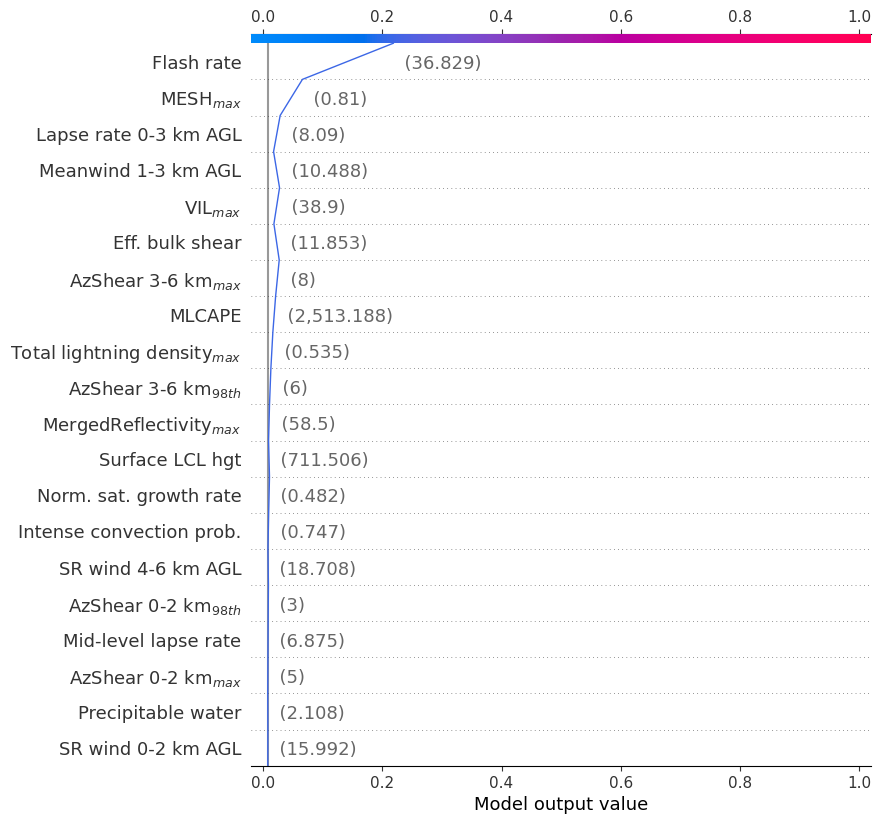

In [ ]:
model = "psv3_lgb_classifier.pkl"
rad_obj_file = "examples/wet_microburst.pickle"
timestamp = "20230705-2348"

storm_shap(model, rad_obj_file, timestamp, decision=True, link="logit")

You can see the final probability of severe was only 21% at this time. The flash rate is the main predictor that is helping. None of the radar, satellite, lightning (except flash rate), or environmental fields look terribly impressive.

The leftward deflections for the meanwind 1-3 km and effective bulk shear show that the paltry environmental flow in the low- and mid-troposphere are decreasing the probability of severe. We can see this better if we change `link` to `"identity"`

[LightGBM] [Warning] min_data_in_leaf is set=32400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32400
[LightGBM] [Warning] feature_fraction is set=0.5333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333333333333333
[LightGBM] [Warning] lambda_l2 is set=0.16326530612244897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16326530612244897
[LightGBM] [Warning] lambda_l1 is set=0.7142857142857142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7142857142857142
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.218
                          PREDICTOR    VALUE    SHAP
0                        Flash rate    36.83   1.374
1                      MESH$_{max}$     0.81   0.874
2             Lapse rate 0-3 km AGL     8.09   0.497
3                       VIL$_{max}$     38.9   0.428
4     

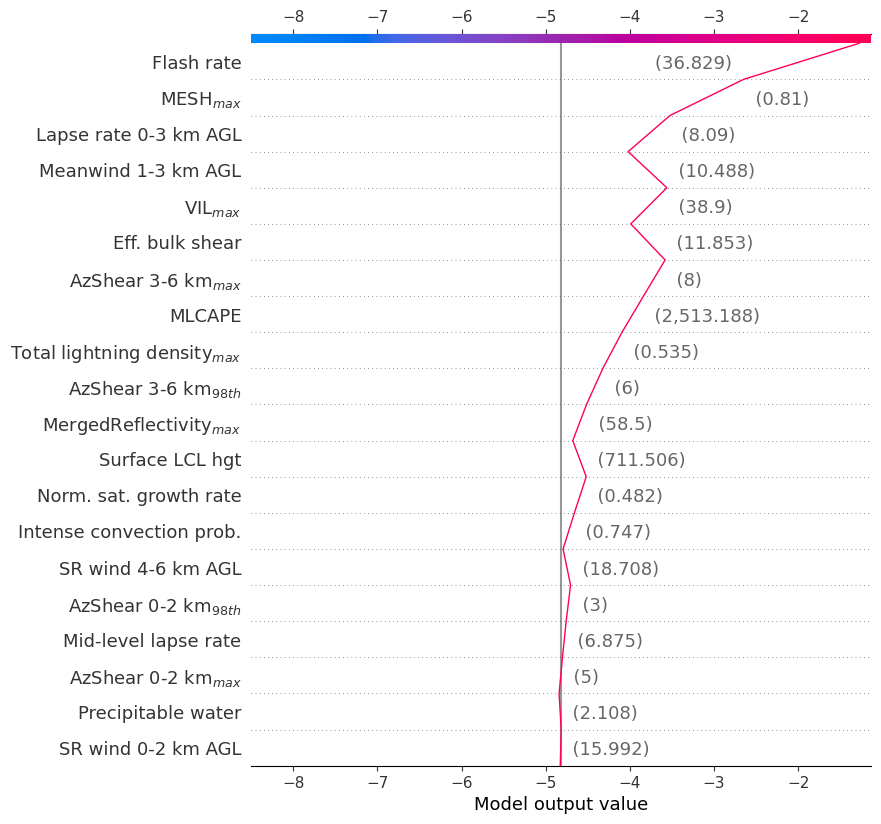

In [ ]:
storm_shap(model, rad_obj_file, timestamp, decision=True, link="identity")

The SHAP values in the colobar of this figure don't have any physical meaning, but they are proportional *relative to each of the other predcitors*. What this means is that while following the "decision" line, the lengths of deflections in the line (i.e., the SHAP values) can be compared directly.

For instance, the negative deflection of the meanwind 1-3 km is about the same in absolute value as the positive deflection produced by the lapse rate 0-3 km. Thus, we can say that the meanwind 1-3 km *cancels out* the influence of the lapse rate 0-3 km. We see this cancelation again with the VIL and effective bulk shear, and with the satellite growth rate LCL height.

Thus, using `link="identity"` is very helpful when directly comparing the SHAP importances of different predictors.

This storm eventually got up to probability of severe = 33% before producing a 69 mph wind gust in the Memphis, TN suburbs. While 33% isn't terribly high, the heightened situational awareness that elevated ProbSevere probabilities can provide forecasters in a marginal severe-weather regime can be very valuable.


### Dry microburst

Dry microbursts are also difficult to predict. They can be small, isolated, short-lived, and there is are usually only subtle radar signatures, which can be short-lived. Like wet microbursts, the signatures can occur inbetween radar scans.

Below is a sounding from a severe-wind producing microburst near Salt Lake City, Utah. There is often little atmospheric instability associated with dry microbursts, but this one had decent elevated CAPE, with instability beginning at about 600 mb. Notice the dry layer from the surface to 600 mb. This dry layer leads to evaporative cooling of rain shafts, and can produce swift downburst wind gusts as a result of *negative buoyancy*.


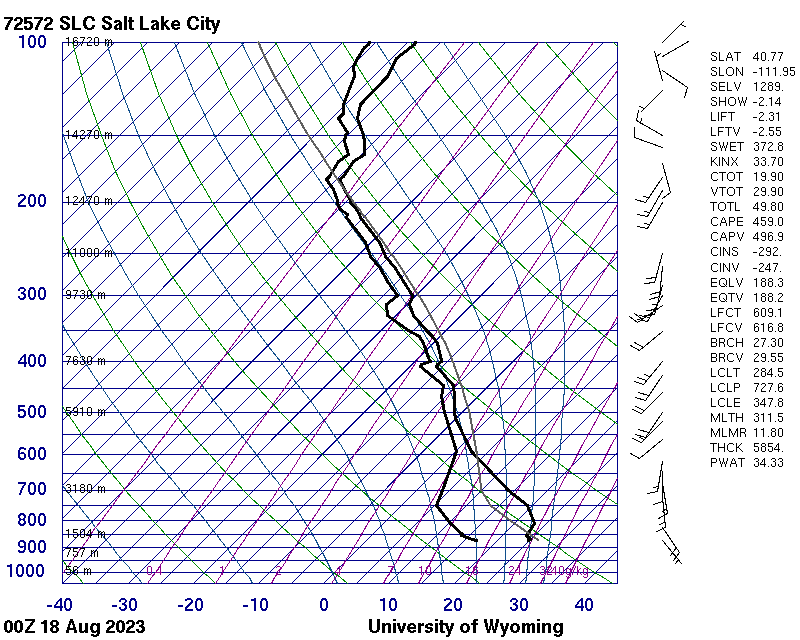



Look at the satellite imagery. The area to focus on is north of the Great Salt Lake, around 00:30 to 01:30 UTC. A storm forms on the northwest bank of the lake.

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-18_ABI_RadC_C02_20230817_2101_to_0818_0301_animSLC.gif">

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-18_ABI_RadC_C13_20230817_2101_to_0818_0301_animSLC.gif">

Now let's look at the ProbSevere predictor importance for this storm, using `link="identity"` to put it into log-odds-space.

[LightGBM] [Warning] min_data_in_leaf is set=32400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32400
[LightGBM] [Warning] feature_fraction is set=0.5333333333333333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333333333333333
[LightGBM] [Warning] lambda_l2 is set=0.16326530612244897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16326530612244897
[LightGBM] [Warning] lambda_l1 is set=0.7142857142857142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7142857142857142
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.431
                          PREDICTOR    VALUE    SHAP
0                      MESH$_{max}$     0.87   0.766
1                        Flash rate    10.89   0.642
2             Lapse rate 0-3 km AGL     9.15    0.64
3                       VIL$_{max}$     35.1   0.437
4     

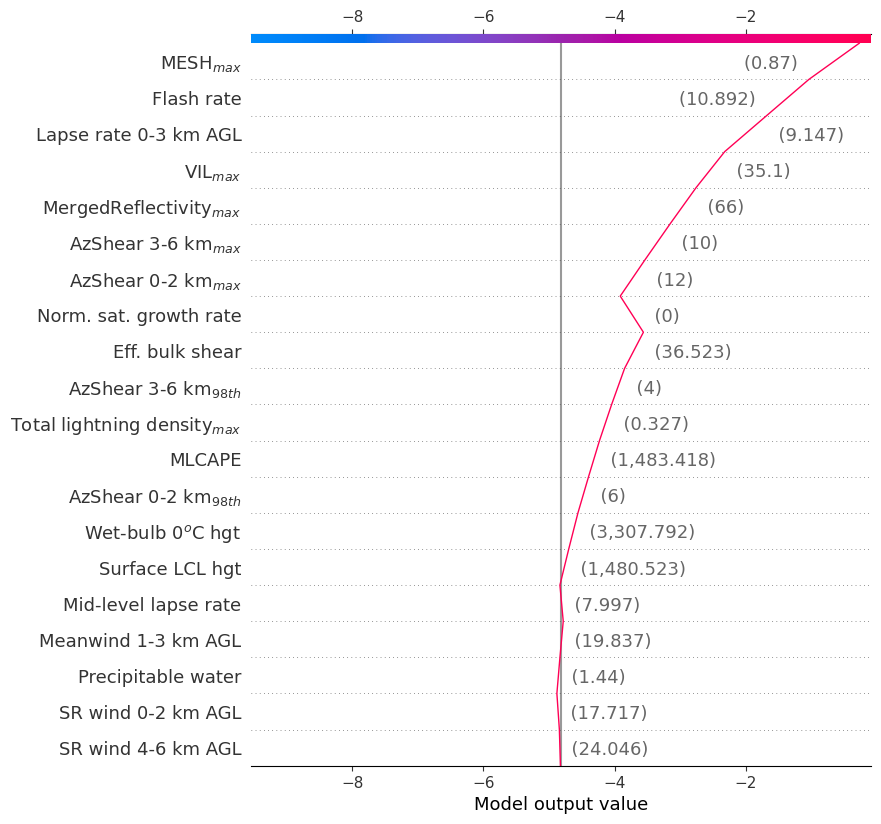

In [ ]:
model = "psv3_lgb_classifier.pkl"
rad_obj_file = "examples/dry_microburst.pickle"
timestamp = "20230818-0116"

storm_shap(model, rad_obj_file, timestamp, decision=True, link="identity")

The probability of severe was 41% for this storm at this time. You can see here that the MESH, VIL, and composite reflectivity were important, depsite being modest in value. The low total lightning flash rate (11 fl/min) was also very important.

A distinctive feature of dry microbursts are very high low-level lapse rates. Here, the lapse rate 0-3 km was 9.15 C/km (from the HRRR), which is close to the dry adiabatic lapse rate. We believe that the model has learned that modest flash rates and/or reflectivity-based parameters in the presence of a very strong low-level lapse rate is indicative of elevated severe weather chances. In essence, what goes up (the updraft, as evidenced by hydrometeors in the reflectivity core), must come down. And what comes down has a better chance of reaching the ground at high speed if the lapse rate is very strong.

We also see the absence of a satellite growth rate penalizes the model, such that it cancels out the effective bulk shear. A decent satellte growth rate would likely help the model a lot; first by not penalizing it, and second by adding positively to the probability. However, satellite growth can be difficult to discern if there is a lot of thick cirrus in the vicinity.

Thirty minutes after the analyzed time, the storm produced a 65 mph wind gust northwest of Salt Lake City.

### Tornadic supercell

A supercell in Texas developed quickly in a very favorable envrionment. In the animation below, the outer storm contours are colored by the probability of tornado computed by the ProbTor model. The yellow and red boxes are official NWS severe thunderstorm and tornado warnings. A tornado warning was issued on the storm in the middle of the scene when the probability of tornado was about 50%. See this [blog post](https://goesrhwt.blogspot.com/2022/04/salado-tornado.html) for more details on the storm.

<img src="https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjfSQU-vGlymJju4lBfl3kBfgecfRzUh6T3P4cmSWmJu3zbCeufl7lPJ9dchu0D5k-OHuOixUbsBYcqsQf2kRmW_M0In_tBLqLIAaa4bKGUcjdi2TTgflWq3qshqYuDsuDGXxDEGkVJlumjnQPghbvZLsFYHyzuM3vvvwBclrswRaw3TU5NH0-pTEQ7/s1536/TX_20220412.gif" width=75%>



In the southern end of the convective mass, notice the very strong overshooting top and associated above-anvil cirrus plume in the visible imagery, and the corresponding "cold-U" signature in the infrared imagery.

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C02_20220412_1801_to_235617_SALADOanim.gif">

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C13_20220412_1801_to_235617_SALADOanim.gif">

Let's run the SHAP feature importance function on this storm for 22:14 UTC.

[LightGBM] [Warning] min_data_in_leaf is set=36600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.12244897959183673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12244897959183673
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.347
                     PREDICTOR    VALUE    SHAP
0                       MLCAPE  3393.11   1.015
1              Eff. bulk shear    50.56   0.757
2                 MESH$_{max}$     1.28   0.736
3        Lapse rate 0-3 km AGL     8.79   0.654
4     Intense convection prob.     0.99   0.618
5                   Flash rate    39.98   0

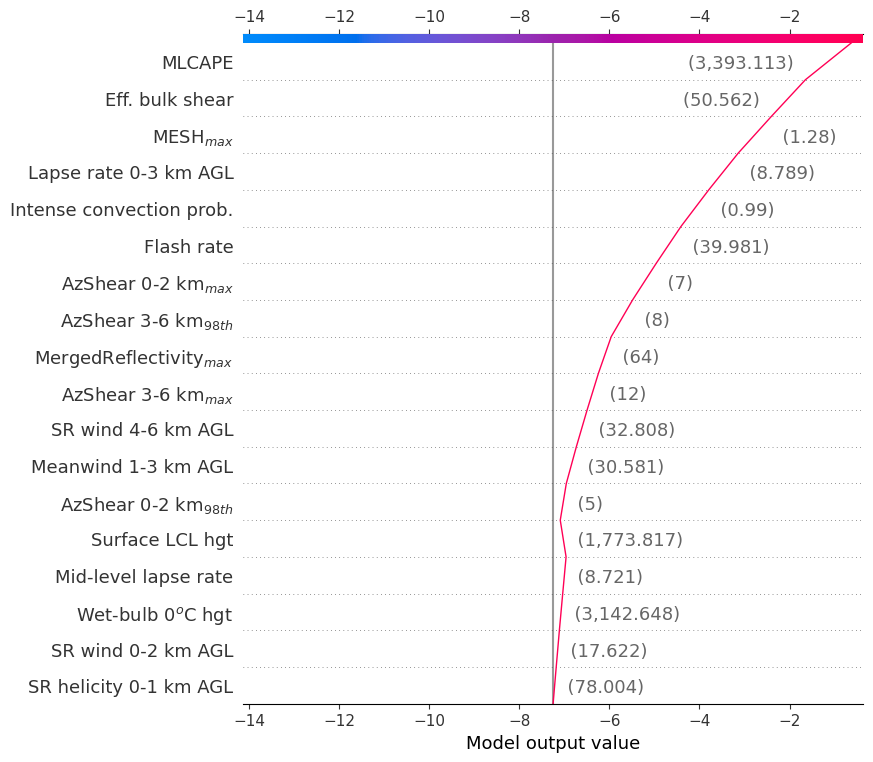

In [ ]:
model = "ptv3_lgb_classifier.pkl"
rad_obj_file = "examples/salado_tornado.pickle"
timestamp = "20220412-2214"

storm_shap(model, rad_obj_file, timestamp, decision=True, link="identity")

The probability of tornado at this time was 35%. We can see in the image above that the rotational radar parameters, the "AzShears", are not very high, but are helping somewhat. There is moderate rotation. The favorable environment parameters of MLCAPE (3400 J/kg) and effective bulk shear (50.5 kt) were the top two predictors at this time. The strong MESH, indicating a good updraft was the third best predictor. The low-level lapse rate, also indicative of strong instability, was fourth. The Intense convection probability from [IntenseStormNet](https://cimss.ssec.wisc.edu/severe_conv/training/Cintineo_Weather_Forecast_Dec2020.pdf) was fifth best, at 99%. IntenseStormNet uses GOES-R ABI and GLM images to compute a probability of "intense" convection from a satellite perspective.

Clearly all of these predictors were pointing to a strong supercell with moderate rotation, capable of producing a tornado.

#### Exercise

Try changing the time to 22:28 UTC, when a tornado was first reported.

- How strong is the probability at 22:28 UTC?
- What differences do you notice between this time and 22:14?
- How important are the rotation predictors at this time? Are they more or less important than the satellite-based intense convection probability?
- Are there any predictors that are reducing the final probability of tornado?

[LightGBM] [Warning] min_data_in_leaf is set=36600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.12244897959183673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12244897959183673
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.522
                     PREDICTOR    VALUE    SHAP
0       AzShear 0-2 km$_{max}$     19.0    1.48
1                       MLCAPE  3393.11   0.939
2              Eff. bulk shear     50.6   0.741
3        Lapse rate 0-3 km AGL     8.62   0.594
4      AzShear 3-6 km$_{98th}$     11.5   0.567
5                 MESH$_{max}$     1.14   0

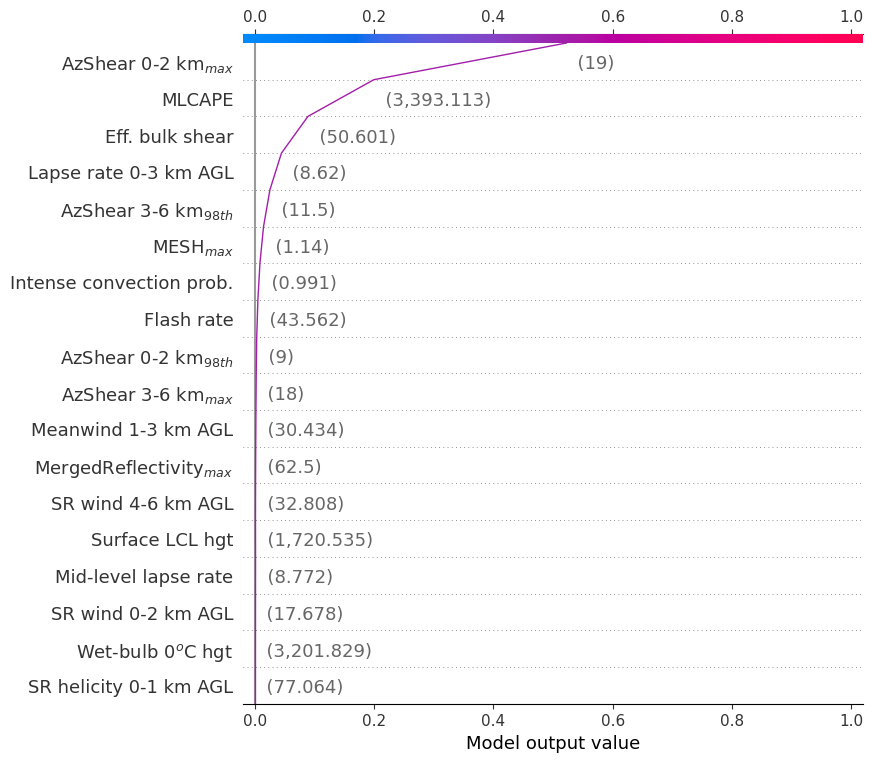

In [ ]:
model = "ptv3_lgb_classifier.pkl"
rad_obj_file = "examples/salado_tornado.pickle"
timestamp = "20220412-2228" # Add the time here

storm_shap(model, rad_obj_file, timestamp, decision=True, link="logit")

### Strong tornadic supercell

On April 26, 2024, a number of strong storms developed tornadoes in Nebraska and Iowa. One storm in particular wreaked havoc on Lincoln and Omaha, Nebraska.

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C02_20240426_1501_to_2201animOMA.gif">

<img src="https://cimss.ssec.wisc.edu/training/ShortCourse2024/GOES-16_ABI_RadC_C13_20240426_1501_to_2201animOMA.gif">

Notice the line of storms heading north-northeast through eastern Nebraska. There are some overshooting tops. Can you find an above-anvil cirrus plume?

#### Excercise

Using the code box below, compare and contrast the decision plots from 20240426 at 18:34 and 19:08 UTC. What are the top three contributors at each time, and how much probability percentage are each contributing? [hint: use the right `link` in `storm_shap`]

[LightGBM] [Warning] min_data_in_leaf is set=36600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36600
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.12244897959183673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12244897959183673
[LightGBM] [Warning] bagging_fraction is set=0.5333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5333333333333333
This model probability:  0.708
                     PREDICTOR    VALUE    SHAP
0       AzShear 0-2 km$_{max}$     20.0   1.663
1          Meanwind 1-3 km AGL    47.82   0.841
2              Eff. bulk shear    55.18   0.823
3      AzShear 3-6 km$_{98th}$      6.0   0.575
4                   Flash rate    35.74   0.534
5                 MESH$_{max}$      1.4   0

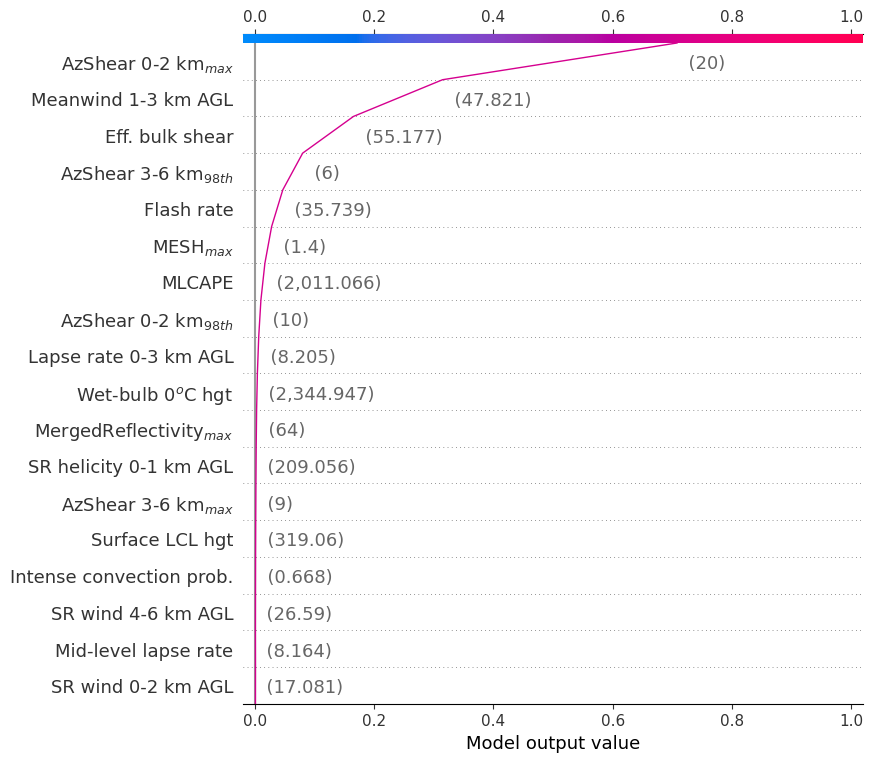

In [ ]:
model = "ptv3_lgb_classifier.pkl"
rad_obj_file = "examples/Nebraska_20240426.pickle"
timestamp = "20240426-1908" # Change the timestamp here (e.g., 20240426-1800)

storm_shap(model, rad_obj_file, timestamp, decision=True, link="logit") # Change the link string

## Summary Questions

1.   In plain language, explain what SHAP values mean.
2.   What is the difference between `link="identity"` and `link="logit"`? When might you want use one method or the other?
3.   What part of the storm life cycle do satellite predictors seem to help the most?
4.   List two or three differences you noticed in predictor importances among the different storm type examples.

